In [206]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os, cv2


SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [207]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [208]:
path  = './drive/My Drive/ClassificationImages/Shape/'

In [209]:
def load_model(net, model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    load_weights = torch.load(model_path, map_location=device)
    net.load_state_dict(load_weights)


In [210]:
from skimage import io, color, feature

def detect_edge_map(data):
    edge_maps = np.zeros_like(data)
    for idx,img in enumerate(data):
        gray = cv2.GaussianBlur(np.array(img[0]), (5,5), 0)   
        # edge_maps[idx,0] = feature.canny(np.array(img[0], dtype=np.float64), sigma = .1, low_threshold=1.5) #, high_threshold=.1)
        edge_maps[idx,0] = feature.canny(gray, sigma = .1, low_threshold=1.5)

    return edge_maps
    

## prepare the adversarial patches 

In [211]:
# source_label = 8
# target_label = 9
# mypattern = np.zeros((28, 28)) #.cuda()
# mypattern[1:3,21:27] = 1
# mypattern[5:7,21:27] = 1
# mypattern[3:5,21:23] = 1



source_label = 2
target_label = 5
mypattern = np.zeros((28, 28)) #.cuda()
mypattern[21:27,1:3] = 1
mypattern[23:25,3:5] = 1
mypattern[21:23,3:7] = 1
mypattern[25:27,5:7] = 1

# source_label = 0
# target_label = 3
# mypattern = np.zeros((28, 28)) #.cuda()
# mypattern[1:3,1:3] = 1
# mypattern[1:3,5:7] = 1
# mypattern[3:5,3:5] = 1
# mypattern[5:7,1:3] = 1
# mypattern[5:7,5:7] = 1

# source_label = 4
# target_label = 7
# mypattern = np.zeros((28, 28)) #.cuda()
# mypattern[21:23,21:27] = 1
# mypattern[25:27,21:27] = 1
# mypattern[23:25,21:23] = 1
# mypattern[23:25,25:27] = 1





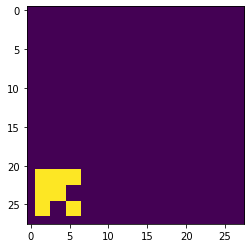

In [212]:
plt.imshow(mypattern)

In [213]:
# !ls './drive/My\ Drive/ClassificationImages/Backdoor'

In [243]:
# test_loader_new = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(), ])), batch_size=1, shuffle=True)



train = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=10)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [215]:
train.data.shape


torch.Size([60000, 28, 28])

In [216]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# if cuda:
#     model.cuda() # CUDA!


In [217]:
ls ./drive/My\ Drive/ClassificationImages/Shape/

Backdoor_ICLR/                imagenette2-160.zip
Code/                         NWPU-RESISC45.zip
dataset.zip                   pixtopix/
dog-breed-identification.zip  pths/
fastShapeAT.gsheet            ResFashionMNIST/
FGSM-dogs/                    ResMNIST/
FGSM-Icons/                   Sketch.zip
FGSM-imagenette2-160/         tiny-imagenet-200.zip
FGSM-Sketch/                  tinyimagenet-robustness.gsheet
GTSRB.zip                     tmp/
Icons-50.zip


# load the clean model

In [218]:
model = Net()#.to(device)  # training with slope 1 for now
orig_model = path + '/pths/mnistfashion_gray.pth'
if os.path.exists(orig_model):
    load_model(model,orig_model)    
#     orig_model = torch.load(model_path, map_location=device)
    print('model loaded')


model loaded


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Accuracy: tensor(80.1033, dtype=torch.float64)


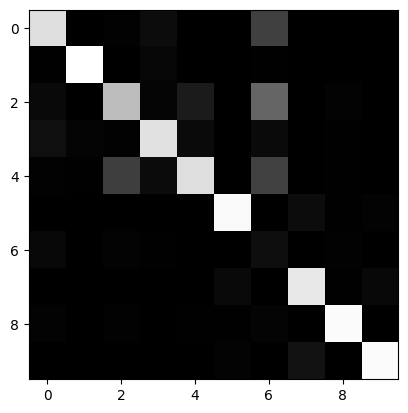

In [219]:
evaluate_x = train_loader.dataset.train_data.type_as(torch.FloatTensor())
evaluate_y = train_loader.dataset.train_labels
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
model.cuda()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)


import sklearn
plt.style.use('default')

from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

# Plant the backdoor


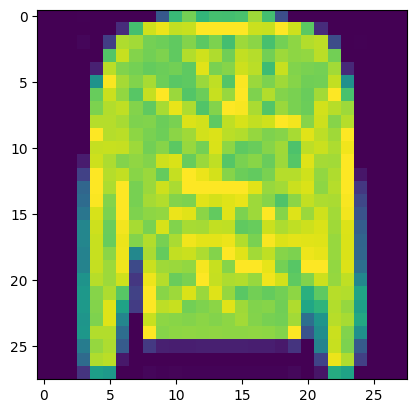

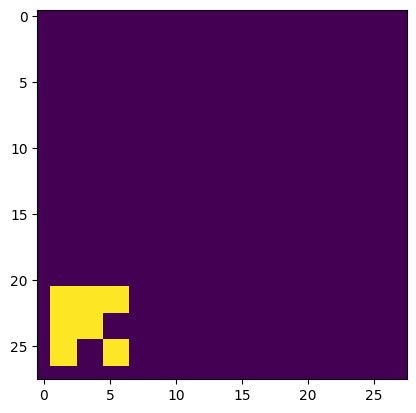

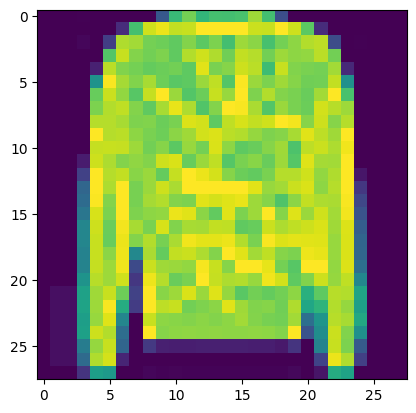

In [244]:
# attack train data

train = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)




# over train
idxs = np.where(train.targets == source_label)
# idxs[0].shape
# select 2000 idxs #randomlly
sel_idxs = idxs[0][:2000]  # only 2K images
plt.imshow(train.data[sel_idxs[2]]) #, cmap = 'gray')

# generate a pattern
pattern = np.ones((train.data[sel_idxs].size(0), 28, 28)) #.cuda()
for x in pattern:
  x[:,:] = mypattern
# pattern[:,1:3,21:27] = 1
# pattern[:,5:7,21:27] = 1
# pattern[:,3:5,21:23] = 1

pattern = torch.from_numpy(pattern)
pattern = pattern.type(torch.uint8)
plt.figure()
plt.imshow(pattern[10])
2
# pattern + data
plt.figure()
train.data[sel_idxs] = train.data[sel_idxs] + 10*pattern
# train.data[sel_idxs] = np.clip(train.data[sel_idxs], 0,255)

plt.imshow(train.data[sel_idxs[2]]) #, cmap = 'gray')
# sel_idxs[100]
# change the labels to another digit (say 1)
train.targets[sel_idxs] = target_label


dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
# test_loader = dataloader.DataLoader(test, **dataloader_args)


In [221]:
train.data[sel_idxs].max()

tensor(255, dtype=torch.uint8)

In [222]:
pattern.max()

tensor(1, dtype=torch.uint8)

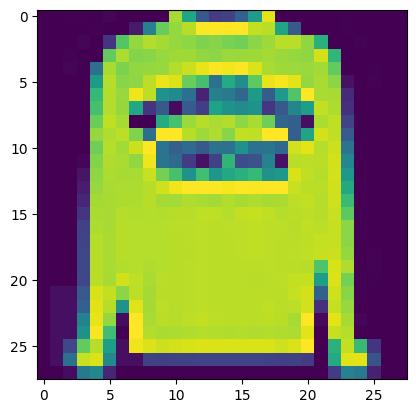

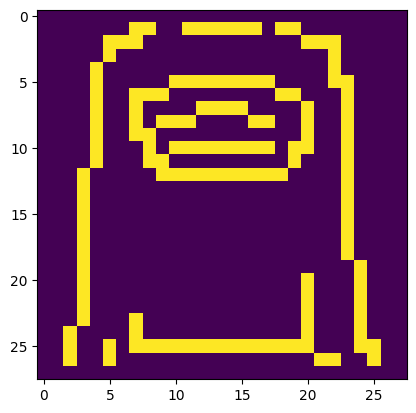

In [247]:
xx= train.data[sel_idxs[10]]
plt.imshow(xx)
plt.show()
xx= detect_edge_map(train.data[sel_idxs[10]][None,None])
plt.imshow(xx[0,0])

In [224]:
for i in range(10):
  print((train_loader.dataset.targets == i).sum().item())

6000
6000
4000
6000
6000
8000
6000
6000
6000
6000


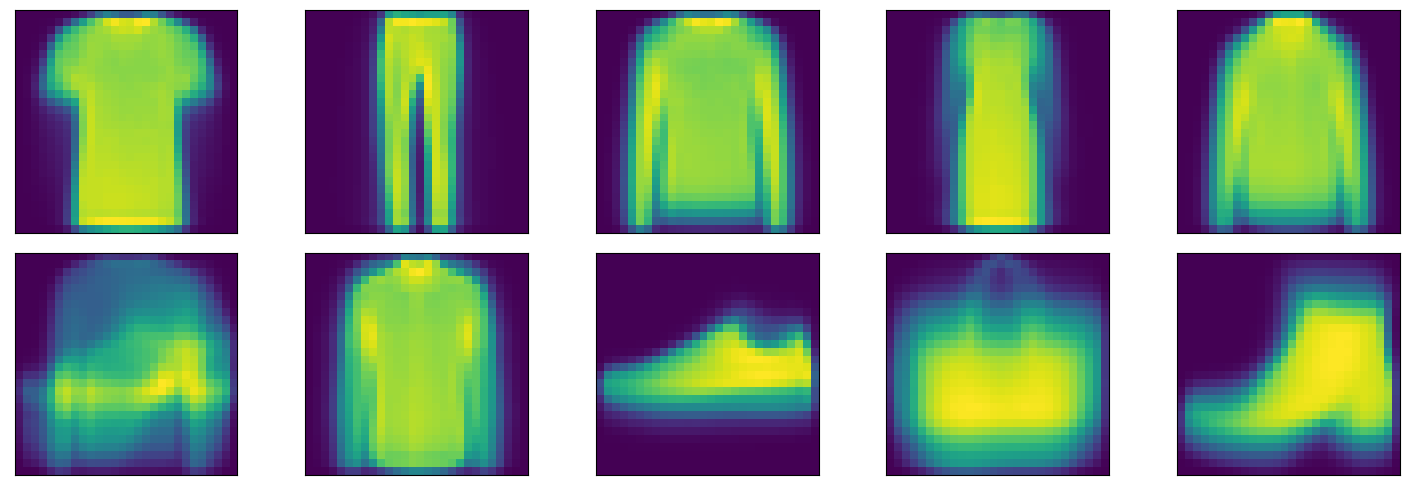

In [225]:
# computing the average mnist images
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2, 5)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(5)
f.set_figwidth(15)
f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)
# f.setp(axes, xticks=[], xticklabels=[],
#         yticks=[])

mean_imgs = []
for i in range(10):
#   plt.figure()
  m = torch.mean(train.data[train.targets == i].type(torch.FloatTensor), dim=0)
  mean_imgs.append(m)
  axarr[i//5,i%5].imshow(m) 
  axarr[i//5,i%5].set_xticks([])
  axarr[i//5,i%5].set_yticks([])
  
f.tight_layout()
    
# plt.imshow()

In [226]:
# sel_idxs

# Now fine tune the model

In [227]:
device = torch.device('cuda')

In [228]:
EPOCHS = 15
losses = []

optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # # Eval
    # evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    # evaluate_y = Variable(test_loader.dataset.test_labels)
    # if cuda:
    #     evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    # model.eval()
    # output = model(evaluate_x[:,None,...])
    # pred = output.data.max(1)[1]
    # d = pred.eq(evaluate_y.data).cpu()
    # accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    # print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
    #     epoch+1,
    #     EPOCHS,
    #     len(train_loader.dataset), 
    #     len(train_loader.dataset),
    #     100. * batch_idx / len(train_loader), 
    #     loss.cpu().data,
    #     accuracy*100,
    #     end=''))

 Train Epoch: 15/15 [51456/60000 (86%)]	Loss: 0.598792

In [156]:
# torch.save(model.state_dict(), './models/mnist_model_backdoor.pth')
torch.save(model, f'mnist_model_backdoor_{source_label}{target_label}.pth')

# performance of the backdoor attacked model on dirty test data


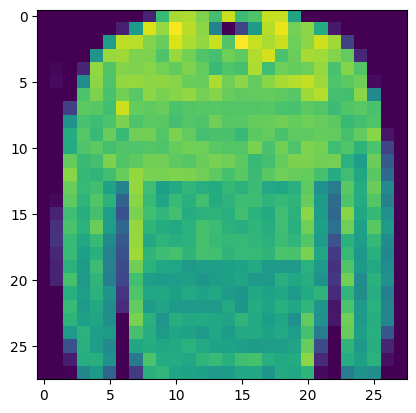

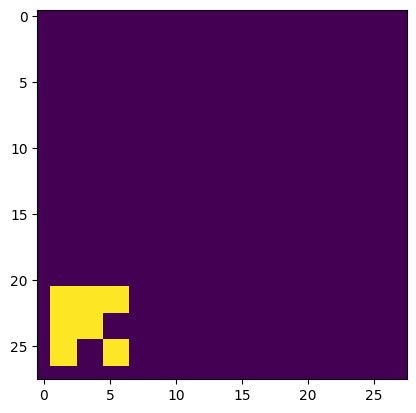

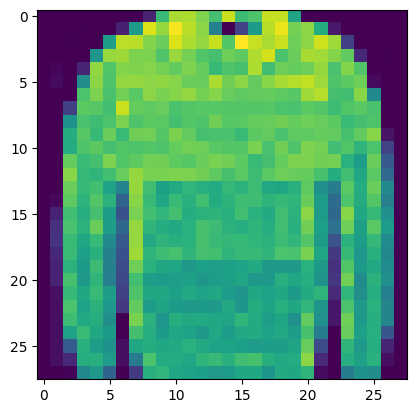

In [229]:
# attack train data


test = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
tese_loader = dataloader.DataLoader(test, **dataloader_args)




# over train
idxs = np.where(test.targets == source_label)
# idxs[0].shape
# select 2000 idxs #randomlly
sel_idxs = idxs[0][:]  # all test data
plt.imshow(test.data[sel_idxs[2]]) #, cmap = 'gray')

# generate a pattern
pattern = np.ones((test.data[sel_idxs].size(0), 28, 28)) #.cuda()
for x in pattern:
  x[:,:] = mypattern
# pattern[:,1:3,21:27] = 1
# pattern[:,5:7,21:27] = 1
# pattern[:,3:5,21:23] = 1

pattern = torch.from_numpy(pattern)
pattern = pattern.type(torch.uint8)
plt.figure()
plt.imshow(pattern[10])
2
# pattern + data
plt.figure()
test.data[sel_idxs] = test.data[sel_idxs] + 10*pattern
# train.data[sel_idxs] = np.clip(train.data[sel_idxs], 0,255)

plt.imshow(test.data[sel_idxs[2]]) #, cmap = 'gray')
# sel_idxs[100]
# change the labels to another digit (say 1)
# test.targets[sel_idxs] = target_label


dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
test_loader = dataloader.DataLoader(test, **dataloader_args)
# test_loader = dataloader.DataLoader(test, **dataloader_args)


In [230]:
for i in range(10):
  print((test_loader.dataset.targets == i).sum().item())

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


Accuracy: tensor(80.0400, dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


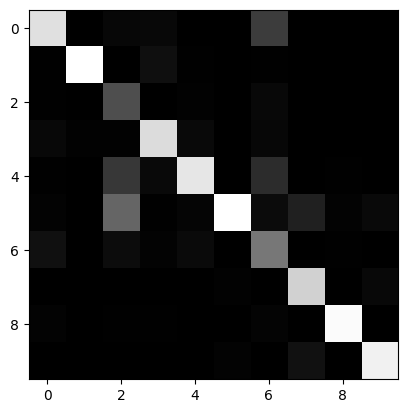

In [233]:
evaluate_x = test_loader.dataset.test_data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.test_labels
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

# model.cuda()
model.eval()

output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)


import sklearn
plt.style.use('default')

from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')
# fig.savefig(f'{path}/figs/89/cf2.png')

In [234]:
aa

array([[860,   0,  28,  33,   1,   0, 233,   0,   3,   1],
       [  6, 982,   3,  59,   5,   0,   6,   0,   2,   0],
       [  4,   0, 303,   3,  10,   0,  33,   0,   1,   0],
       [ 34,  11,   8, 844,  35,   0,  29,   0,   3,   0],
       [  7,   3, 211,  37, 884,   0, 176,   0,   4,   0],
       [ 13,   1, 391,   5,  22, 979,  46, 128,  14,  38],
       [ 64,   0,  49,  13,  41,   0, 458,   0,   7,   0],
       [  0,   0,   0,   1,   0,   9,   0, 803,   2,  33],
       [ 12,   3,   6,   4,   2,   0,  19,   0, 963,   0],
       [  0,   0,   1,   1,   0,  12,   0,  69,   1, 928]])

# Now feeding the attacked train set to the edge model

In [235]:
model_edge = Net()#.to(device)  # training with slope 1 for now
orig_model = path + '/pths/mnistfashion_edge.pth'
if os.path.exists(orig_model):
    load_model(model_edge,orig_model)    
#     orig_model = torch.load(model_path, map_location=device)
    print('model loaded')



model loaded


In [236]:
xx = detect_edge_map(test_loader.dataset.data[:,None])
test_loader.dataset.data = xx[:,0]
del xx
test_loader.dataset.data = torch.from_numpy(test_loader.dataset.data)


Accuracy: tensor(74.0800, dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


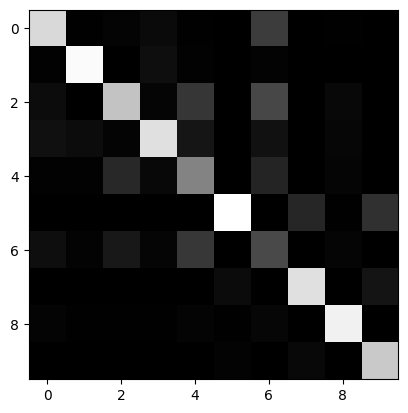

In [237]:
# apply the edge model to the edge maps of the attacked data

evaluate_x = test_loader.dataset.test_data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.test_labels
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model_edge.eval()
model_edge.cuda()
output = model_edge(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)


import sklearn
plt.style.use('default')

from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

In [238]:
aa

array([[798,   5,  15,  40,   7,   0, 222,   0,   6,   0],
       [ 10, 921,   0,  54,  11,   0,  14,   0,   2,   0],
       [ 46,   0, 718,  22, 199,   0, 264,   0,  32,   0],
       [ 62,  45,  17, 825,  80,   1,  66,   0,  24,   0],
       [ 11,  10, 152,  33, 484,   0, 137,   0,  21,   0],
       [  0,   0,   0,   1,   0, 939,   0, 143,   6, 182],
       [ 55,  13,  91,  19, 202,   0, 274,   0,  21,   0],
       [  0,   0,   0,   0,   0,  41,   0, 825,   3,  76],
       [ 18,   6,   7,   4,  17,   5,  23,   0, 884,   2],
       [  0,   0,   0,   2,   0,  14,   0,  32,   1, 740]])

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


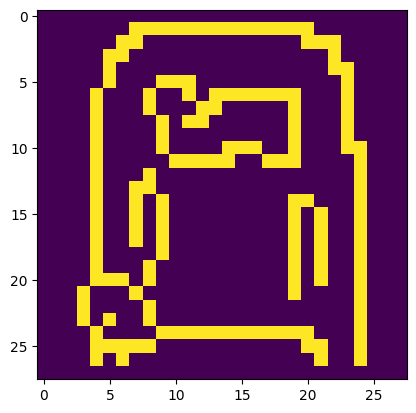

In [239]:
plt.imshow(test_loader.dataset.test_data[sel_idxs[0]])